In [3]:
import string
import re
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx
import nltk
nltk.download('stopwords')

# PREPROCESSING
#----------------
fhr = open(r'C:\Users\VG\Desktop\amazon-meta.txt', encoding='utf-8', errors='ignore')
amazonProducts = {}

# Read data from amazon meta files and popoulate amazon products nested dictionary
(Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = \
    ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
for line in fhr:
    line = line.strip()
    # a product block started
    if(line.startswith("Id")):
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
        
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((fhr.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits + string.punctuation)).sub(' ', Categories)
        Categories = ' '.join(set(Categories.split()) - set(stopwords.words("english")))
        Categories = ' '.join(stem(word) for word in Categories.split())
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()
    # product block end
    # write out fields to amazonProducts dictionary
    elif(line==""):
        try:
            MetaData={}
            if(ASIN != ""):
                amazonProducts[ASIN] = MetaData
            MetaData['Id'] = Id
            MetaData['Title'] = Title
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['DegreeCentrality'] = DegreeCentrality
            MetaData['ClusteringCoeff'] = ClusteringCoeff
        except NameError:
            continue
        (Id, ASIN, Title, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = \
            ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)
fhr.close()

# create books-specific dictionary exclusively for books
amazonBooks = {}
for asin,metadata in amazonProducts.items():
    if (metadata['Group']=='Book'):
        amazonBooks[asin] = amazonProducts[asin]

# remove any copurchased items from copurchase list if we don't have metadata associated with it
for asin, metadata in amazonBooks.items():
    amazonBooks[asin]['Copurchased'] = \
        ' '.join([cp for cp in metadata['Copurchased'].split() \
                  if cp in amazonBooks.keys()])

# Create a product copurchase graph for analysis where the graph nodes for product ASINs
# and graph edge exists if two products were copurchased,
# with edge weight being a measure of category similarity between ASINs
amazonBooks['0827229534']['Copurchased'].split()
    
copurchaseGraph = networkx.Graph()
for asin,metadata in amazonBooks.items():
    copurchaseGraph.add_node(asin)
    for a in metadata['Copurchased'].split():
        copurchaseGraph.add_node(a.strip())
        similarity = 0
        n1 = set((amazonBooks[asin]['Categories']).split())
        n2 = set((amazonBooks[a]['Categories']).split())
        n1In2 = n1 & n2     # intersection (Number of words that are common between Categories of connected Nodes)
        n1Un2 = n1 | n2     # union (Total number of words in both Categories of connected Nodes)
        if(len(n1Un2)) > 0:
            similarity = round(len(n1In2)/len(n1Un2), 2)
        copurchaseGraph.add_edge(asin, a.strip(), weight=similarity)

# Get Degree Centrality and clustering coefficients
# of each ASIN and add it to amazonBooks metadata
dc = networkx.degree(copurchaseGraph)
for asin in networkx.nodes(copurchaseGraph):
    metadata = amazonBooks[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = networkx.ego_graph(copurchaseGraph, asin, radius=1)
    metadata['ClusteringCoeff'] = networkx.triangles(ego)
    amazonBooks[asin] = metadata
    
counter = 0
for f,t,e in copurchaseGraph.edges(data=True):
    if counter == 150:
        break
    print(e['weight'])
    counter += 1
    


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0.7
0.5
0.8
0.8
0.7
0.7
0.7
0.7
0.7
0.75
1.0
0.9
0.78
0.39
0.5
0.39
0.6
0.33
0.78
1.0
0.45
0.9
1.0
0.78
0.64
0.7
0.78
0.9
0.9
0.64
0.6
0.78
0.64
0.64
0.44
0.78
1.0
1.0
0.5
0.4
0.23
0.28
0.44
0.44
0.47
0.47
0.26
0.39
0.44
0.39
0.68
0.94
0.44
0.21
0.33
0.44
0.14
0.33
0.39
0.32
0.39
0.44
0.83
0.8
0.58
0.1
0.8
1.0
0.7
0.7
0.58
0.7
0.28
0.62
0.47
0.9
0.9
0.42
0.58
0.58
0.7
0.69
0.46
0.47
0.43
0.64
0.57
0.35
0.53
0.5
0.73
0.31
0.17
0.4
0.57
0.42
0.88
0.88
1.0
0.79
0.1
0.87
0.48
0.81
0.71
0.75
0.19
0.1
0.34
0.39
0.41
0.48
0.48
0.39
0.42
0.48
0.16
0.32
0.31
0.42
0.26
0.94
0.73
0.81
0.59
0.45
0.25
0.69
0.88
0.76
0.63
0.88
0.85
0.69
0.55
0.36
0.79
1.0
0.9
0.9
0.9
0.9
0.9
0.56
0.62
0.9
0.9
0.9
0.86
0.9


'fhw = open(\'amazon-books.txt\', \'w\', encoding=\'utf-8\', errors=\'ignore\')\nfhw.write("Id\t" + "ASIN\t" + "Title\t" + "Categories\t" + "Group\t" + "Copurchased\t" + "SalesRank\t" + "TotalReviews\t" + "AvgRating\t" + "DegreeCentrality\t" + "ClusteringCoeff\n")\nfor asin, metadata in amazonBooks.items():\n    fhw.write(metadata[\'Id\'] + "\t" +               asin + "\t" +               metadata[\'Title\'] + "\t" +               metadata[\'Categories\'] + "\t" +               metadata[\'Group\'] + "\t" +               metadata[\'Copurchased\'] + "\t" +               str(metadata[\'SalesRank\']) + "\t" +               str(metadata[\'TotalReviews\']) + "\t" +               str(metadata[\'AvgRating\']) + "\t" +               str(metadata[\'DegreeCentrality\']) + "\t" +               str(metadata[\'ClusteringCoeff\']) + "\n")\nfhw.close()\n\n# Write copurchaseGraph data to file\nfhw = open(\'amazon-books-copurchase.edgelist\', \'wb\')\nnetworkx.write_weighted_edgelist(copurchaseGraph, fh

In [5]:
import networkx as nx 
#list(copurchaseGraph.nodes)
nx.info(copurchaseGraph)

'Name: \nType: Graph\nNumber of nodes: 393561\nNumber of edges: 741124\nAverage degree:   3.7662'

In [23]:
type(copurchaseGraph)

networkx.classes.graph.Graph

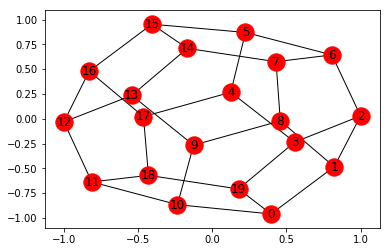

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
#G=nx.dodecahedral_graph(copurchaseGraph)
#G = networkx.layout.spring_layout(copurchaseGraph)
nx.drawing.nx_pylab.draw_networkx(copurchaseGraph, pos=None, arrows=True, with_labels=True) 

plt.draw()

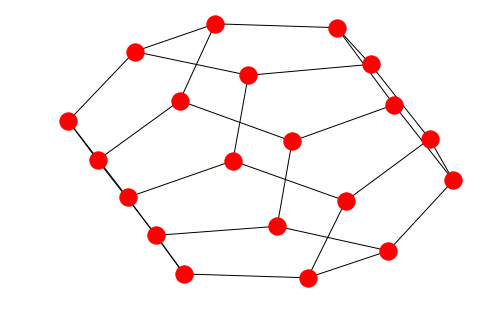

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
positions = nx.spring_layout( copurchaseGraph)

nx.draw( copurchaseGraph, positions )
plt.draw()

KeyError: ''

In [14]:

#amazonProducts

In [21]:
#amazonBooks

{'0827229534': {'Id': '1',
  'Title': 'Patterns of Preaching: A Sermon Sampler',
  'Categories': 'subject clergi spiritu book sermon preach religion christian',
  'Group': 'Book',
  'Copurchased': '0804215715 156101074X 0687023955 0687074231 082721619X',
  'SalesRank': 396585,
  'TotalReviews': 2,
  'AvgRating': 5.0,
  'DegreeCentrality': 8,
  'ClusteringCoeff': 0.8},
 '0738700797': {'Id': '2',
  'Title': 'Candlemas: Feast of Flames',
  'Categories': 'earth subject wicca witchcraft spiritu book religion base',
  'Group': 'Book',
  'Copurchased': '0738700827 1567184960 1567182836 0738700525 0738700940',
  'SalesRank': 168596,
  'TotalReviews': 12,
  'AvgRating': 4.5,
  'DegreeCentrality': 9,
  'ClusteringCoeff': 0.85},
 '0486287785': {'Id': '3',
  'Title': 'World War II Allied Fighter Planes Trading Cards',
  'Categories': 'subject book garden craft hobbi general home',
  'Group': 'Book',
  'Copurchased': '',
  'SalesRank': 1270652,
  'TotalReviews': 1,
  'AvgRating': 5.0,
  'DegreeCent

In [ ]:
import networkx as nx
import matplotlib as plt
g = nx.DiGraph(amazonBooks)
nx.draw(g,with_labels=True)
plt.draw()
plt.show()

In [12]:
import string
import re
from nltk.corpus import stopwords
from stemming.porter2 import stem
import networkx
import nltk
nltk.download('stopwords')

# RECOMMENDATIONS
#-----------------
import networkx
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib as mpl

'''# Read the data from the amazon-books.txt and populate amazonProducts nested dictionary
# key = ASIN; value = MetaData associated with ASIN
fhr = open('amazon-books.txt', 'r', encoding='utf-8', errors='ignore')
amazonBooks = {}
fhr.readline()
for line in fhr:
    cell = line.split('\t')
    MetaData = {}
    MetaData['Id'] = cell[0].strip()
    ASIN = cell[1].strip()
    MetaData['Title'] = cell[2].strip()
    MetaData['Categories'] = cell[3].strip()
    MetaData['Group'] = cell[4].strip()
    MetaData['Copurchased'] = cell[5].strip()
    MetaData['SalesRank'] = int(cell[6].strip())
    MetaData['TotalReviews'] = int(cell[7].strip())
    MetaData['AvgRating'] = float(cell[8].strip())
    MetaData['DegreeCentrality'] = int(cell[9].strip())
    MetaData['ClusteringCoeff'] = float(cell[10].strip())
    amazonBooks[ASIN] = MetaData
fhr.close()

# Read the data from amazon-books-copurchase.edgelist and assign it to copurchaseGraph weighted Graph;
# node = ASIN; edge = copurchase, edge weight = category similarity
fhr = open("amazon-books-copurchase.edgelist", "rb")
copurchaseGraph = networkx.read_weighted_edgelist(fhr)
fhr.close()'''

# Now let's assume a person is considering buying the following book;
print("Looking for Recommendations for Customer purchasing this Book:")
print("\n------------------------------------------------------------")
# purchasedAsin = '0805047905'
purchasedAsin = '0875421210'

# Let's first get some metadata associated with this book
print("ASIN = ", purchasedAsin)
print("Title = ", amazonBooks[purchasedAsin]['Title'])
print("SalesRank = ", amazonBooks[purchasedAsin]['SalesRank'])
print("TotalReviews = ", amazonBooks[purchasedAsin]['TotalReviews'])
print("AvgRating = ", amazonBooks[purchasedAsin]['AvgRating'])
print("DegreeCentrality = ", amazonBooks[purchasedAsin]['DegreeCentrality'])
print("ClusteringCoeff = ", amazonBooks[purchasedAsin]['ClusteringCoeff'])

# Get the depth-1 ego network of purchasedAsin from copurchaseGraph
n = purchasedAsin
ego = networkx.ego_graph(copurchaseGraph, n, radius=1)
purchasedAsinEgoGraph = networkx.Graph(ego)
pos = networkx.layout.spring_layout(purchasedAsinEgoGraph)
M = purchasedAsinEgoGraph.number_of_edges()
nodes = networkx.draw_networkx_nodes(purchasedAsinEgoGraph, pos, node_size=50, node_color='blue')
edges = networkx.draw_networkx_edges(purchasedAsinEgoGraph, pos, node_size=50, edge_cmap=plt.cm.Blues, width=2, alpha=0.1)
ax = plt.gca()
ax.set_axis_off()
plt.title('Degree-1 Ego Network')
plt.figure(0)
plt.show()

# Use the island method on purchasedAsinEgoGraph to only retain edges with Threshold >= 0.5
threshold = 0.5
purchasedAsinEgoTrimGraph = networkx.Graph()
for f,t,e in purchasedAsinEgoGraph.edges(data=True):
    if e['weight'] >= threshold:
        purchasedAsinEgoTrimGraph.add_edge(f,t, weight=e['weight'])
pos = networkx.layout.spring_layout(purchasedAsinEgoTrimGraph)
M = purchasedAsinEgoTrimGraph.number_of_edges()
nodes = networkx.draw_networkx_nodes(purchasedAsinEgoTrimGraph, pos, node_size=50, node_color='blue', label=True)
edges = networkx.draw_networkx_edges(purchasedAsinEgoTrimGraph, pos, node_size=50, edge_cmap=plt.cm.Blues, width=2, alpha=0.1)
ax = plt.gca()
ax.set_axis_off()
plt.title('Degree-1 Ego Network Trimmed using threshold of 0.5')
plt.figure(1)
plt.show()

# Get the list of nodes connected to the purchasedAsin
purchasedAsinNeighbours = purchasedAsinEgoTrimGraph.neighbors(purchasedAsin)

# Get Top Five book recommendations from among the purchasedAsinNeighbours based on one or more of the following data of the 
# neighbouring nodes: SalesRank, AvgRating, TotalReviews, DegreeCentrality, and ClusteringCoeff

# Accessing metadata with ASIN in purchasedAsinNeighbours
AsMeta = []
for asin in purchasedAsinNeighbours:
    ASIN = asin
    Title = amazonBooks[asin]['Title']
    SalesRank = amazonBooks[asin]['SalesRank']
    TotalReviews = amazonBooks[asin]['TotalReviews']
    AvgRating = amazonBooks[asin]['AvgRating']
    DegreeCentrality = amazonBooks[asin]['DegreeCentrality']
    ClusteringCoeff = amazonBooks[asin]['ClusteringCoeff']
    AsMeta.append((ASIN, Title, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff))
    
# Sorting the top five nodes in purchasedAsinNeighbour by Average Rating then by TotalReviews
T5_byAvgRating_then_byTotalReviews = sorted(AsMeta, key=lambda x: (x[4], x[3]), reverse=True)[:5]

# Print Top 5 Recommendations
print('\nTop 5 Recommendations by AvgRating then by TotalReviews for Users Purchased the book:')
print('\n------------------------------------------------------------------------------------')
print('ASIN\t', 'Title\t', 'SalesRank\t', 'TotalReviews\t', 'AvgRating\t', 'DegreeCentrality\t', 'ClusteringCoeff')
for asin in T5_byAvgRating_then_byTotalReviews:
    print(asin)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking for Recommendations for Customer purchasing this Book:

------------------------------------------------------------
ASIN =  0875421210
Title =  Earth Power: Techniques of Natural Magic (Llewellyn's Practical Magick)
SalesRank =  100261
TotalReviews =  47
AvgRating =  4.5
DegreeCentrality =  14
ClusteringCoeff =  0.67


C:\Users\VG\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 1 Axes>


Top 5 Recommendations by AvgRating then by TotalReviews for Users Purchased the book:

------------------------------------------------------------------------------------
ASIN	 Title	 SalesRank	 TotalReviews	 AvgRating	 DegreeCentrality	 ClusteringCoeff
('0875421229', "Cunningham's Encyclopedia of Magical Herbs (Llewellyn's Sourcebook Series)", 6565, 96, 4.5, 68, 0.65)
('0875421849', "Living Wicca: A Further Guide for the Solitary Practitioner (Llewellyn's Practical Magick)", 6003, 95, 4.5, 30, 0.81)
('0875421318', "Earth, Air, Fire, and Water: More Techniques of Natural Magic (Llewellyn's Practical Magick Series)", 7286, 57, 4.5, 10, 0.73)
('0875421261', "Cunningham's Encyclopedia of Crystal, Gem, and Metal Magic", 14867, 39, 4.0, 17, 0.54)
('0875421245', "The Magical Household: Spells & Rituals for the Home (Llewellyn's Practical Magick Series)", 111836, 21, 4.0, 8, 0.7)


In [20]:
amazonBooks

{'0827229534': {'Id': '1',
  'Title': 'Patterns of Preaching: A Sermon Sampler',
  'Categories': 'subject clergi spiritu book sermon preach religion christian',
  'Group': 'Book',
  'Copurchased': '0804215715 156101074X 0687023955 0687074231 082721619X',
  'SalesRank': 396585,
  'TotalReviews': 2,
  'AvgRating': 5.0,
  'DegreeCentrality': 8,
  'ClusteringCoeff': 0.8},
 '0738700797': {'Id': '2',
  'Title': 'Candlemas: Feast of Flames',
  'Categories': 'earth subject wicca witchcraft spiritu book religion base',
  'Group': 'Book',
  'Copurchased': '0738700827 1567184960 1567182836 0738700525 0738700940',
  'SalesRank': 168596,
  'TotalReviews': 12,
  'AvgRating': 4.5,
  'DegreeCentrality': 9,
  'ClusteringCoeff': 0.85},
 '0486287785': {'Id': '3',
  'Title': 'World War II Allied Fighter Planes Trading Cards',
  'Categories': 'subject book garden craft hobbi general home',
  'Group': 'Book',
  'Copurchased': '',
  'SalesRank': 1270652,
  'TotalReviews': 1,
  'AvgRating': 5.0,
  'DegreeCent